### Food Web Kernel

#### To Do
###### Verification against original Kondoh results
- verify my results on kondoh's original results

###### Additions to be built
- measure frequency of co-occurance at 10^5
- build for multiple runs

###### Things that need fixing
- only works for <10 spp

    - 

#### Current model structure
- random species generation
    - trophic level
    - adaptivity
- mass action food web
    - random connectance





In [1]:
# Packages
using DifferentialEquations
using DiffEqBiological
using Latexify
using Plots
using Catlab

In [2]:
function generate_mass()
    # helper function for "generate_species"
    # makes one draw from improvised prob distribution where most animals are in the
    # 10-100kg range 
    r = rand()
    if r <= 0.25
        mass = rand() * 10
    elseif  r > 0.25 && r <=0.75
        mass = rand() * 100
    elseif r > 0.75
        mass = rand() * 1000
    end
    return mass
end


# model parameters.params fitted to East Africa (egypt paper)
alpha = 1.41
beta = 3.73
gamma = -1.87


function mass_ratio_model(pred_mass, prey_mass)
    # model parameters.params fitted to East Africa (egypt paper)
    alpha = 1.41
    beta = 3.73
    gamma = -1.87
    
    p = exp(alpha + beta * log(pred_mass/prey_mass) + gamma * log(pred_mass/prey_mass)^2)
    prob_interaction = p / (1 + p)
    return prob_interaction
end

mass_ratio_model (generic function with 1 method)

In [3]:
# species generator
function generate_species(number_species, model, adaptivity)
        
    if model == "body mass"
        # creates n species of varying trophic position and body mass
        trophic_type = [0, 1, 2] # 0-plant, 1-herbivore, 2-predator, 3-omnivore
        species_list =  Array{Any,2}(undef, number_species, 2)

        for species in 1:number_species
            trophy = rand(trophic_type)
            species_list[species,1] = trophy
            if trophy == 0
                species_list[species,2] = NaN
                else species_list[species,2] = generate_mass()
                    end # end if tropy ==0
                end # end species loop
        
    
    elseif model == "random"
        species_list =  Array{Any,2}(undef, number_species, 1)
        
        
        for species in 1:number_species # loop through number of species
            #trophic_type = [0, 1] # 0-basal, 1-non-basal
            #trophy = rand(trophic_type) # randomly select basal vs non basal
            #species_list[species,1] = trophy # set first column of species level to it
            
            if rand() <= adaptivity  # adaptivity is the rand chance a sp is adaptive
                species_list[species] = 1
            else
                species_list[species] = 0
                end # end adaptivity
            end #species loop
        end # end else if
      
    return species_list
end
    

generate_species (generic function with 1 method)

In [4]:
function interaction_check(species_list, predator, prey)
# for each j in row i, process the masses with the interaction model
# put the probability of interaction in array position i,j
    int_prob = mass_ratio_model(species_list[predator,2], species_list[prey,2])
    rand_draw = rand()
    
    if rand_draw < int_prob 
        interaction_value = 1
    else
        interaction_value = 0
    end  
    
    return interaction_value
    
end



function body_mass_model(species_list, predator, prey)
    # predator and prey are index positions of species list
    # predator trophic pos = species_list[predator,1]
    # prey trophic pos = species_list[predator,2]
    pred_trophy = species_list[predator,1]
    prey_trophy = species_list[prey,1]
    
    
    if predator == prey
        interaction = 0
    elseif pred_trophy == 1 && prey_trophy == 0
        interaction = 1
    elseif pred_trophy == 2 && prey_trophy != 0
        interaction = interaction_check(species_list, predator, prey)
    elseif pred_trophy == 3 && prey_trophy == 0
        interaction = 1
    elseif pred_trophy == 3 && prey_trophy != 0
        interaction = interaction_check(species_list, predator, prey)
    else
        interaction = 0
    end
    
    return interaction
end

function random_model(connectance, species_i, species_j)
    interaction = 0
    if species_i == species_j
        interaction = 0
        
    elseif species_j>species_i && rand() <= connectance
        r = rand()
        if r < 0.5
            interaction = 1
        elseif r >= 0.5 
            interaction = -1
            end # end if r
        end # end of if connectence
    
    return interaction
    
    end # end of function

function build_interaction_matrix(species_list, model; connectance)
    # takes a Sx2 array of trohpic position and mass
    # constructions an interaction matrix (SxS array) using mass ratio 
    S = length(species_list[:,1])
    number_of_prey = zeros(S)

    int_matrix =zeros(S,S) # create an empty SxS array
    interaction_value = 0
    
    for i in 1:S # loop through rows
        for j in 1:S # loop through columns
                        
            if int_matrix[i,j] == 0
                if model == "body mass"
                    interaction_value = body_mass_model(species_list, i, j)
                    if interaction_value == 1
                        number_of_prey[i] += 1
                    end
                    
                elseif model == "random"
                    interaction_value = random_model(connectance, i, j)
                    #if interaction_value == 1
                        #number_of_prey[i] += interaction_value
                    #end
                    end # end of if model
                #number_of_prey[i] += abs(interaction_value)
                
                if interaction_value == 1
                    number_of_prey[i] += interaction_value
                elseif interaction_value == -1
                    number_of_prey[j] += abs(interaction_value)
                    
                end
                
                int_matrix[i,j] = interaction_value
                int_matrix[j,i] = -(interaction_value)
                end # end of if int_matrix
            end # end of for j
        end # end of for i
    
    return int_matrix, number_of_prey
    end # end of function

build_interaction_matrix (generic function with 1 method)

In [5]:
a,b =build_interaction_matrix(species_list, "random", connectance=0.3);



UndefVarError: UndefVarError: species_list not defined

In [47]:
rn = @empty_reaction_network

generate_ode_system(rn, interaction_matrix, species_list, number_of_prey)
addodes!(rn)   
latexify(rn)

L"\begin{align}
\frac{dX1(t)}{dt} =& r1 \cdot X1 - \frac{s1}{2} \cdot X1^{2} + e13 \cdot X1 \cdot X3 - f21 \cdot X2 \cdot X1 \\
\frac{dX2(t)}{dt} =& r2 \cdot X2 - \frac{s2}{2} \cdot X2^{2} + e21 \cdot X2 \cdot X1 + e23 \cdot X2 \cdot X3 \\
\frac{dX3(t)}{dt} =&  - f13 \cdot X1 \cdot X3 - f23 \cdot X2 \cdot X3 + r3 \cdot X3 - \frac{s3}{2} \cdot X3^{2}
\end{align}
"

In [37]:
sub= print(3,".")

3.

In [46]:
function generate_ode_system(rn, int_matrix, species_list, number_of_prey)
    
    number_species = length(species_list[:,1])
    
######### loops for adding species and parameters ##########
for i in 1:number_species 
     if species_list[i] == 1 && number_of_prey[i] >= 2
            adaptive = true
        else
            adaptive = false
        end
        
        
    # species u
    addspecies!(rn, Symbol(:X, i)) 
    # intrinsic growth parameter [everyone]
    addparam!(rn, Symbol(:r, i))

    # self-limitation parameter 
    addparam!(rn, Symbol(:s, i))

    for j in 1:number_species
        # predator prey interaction terms
        if int_matrix[i,j] == 1.0
            # foraging efficiency parameter [consumers]
                #sub= print(i,".")
            addparam!(rn, Symbol(:e,i,j))
            addparam!(rn, Symbol(:f,i,j))
           # if adaptive == true # what was the thinking here?
              #  addparam!(rn, Symbol(:G,i,j))
            #    end
           
            # adaptive foraging equation and paramters  
                
            #if species_list[i] == 1; #adaptivity gate
             if adaptive == true
                # foraging effort equation [consumers]
                addspecies!(rn, Symbol(:A, i,j))
                addparam!(rn, Symbol(:G,i,j))
                addparam!(rn, Symbol(:Q,i,j))
                end
            end # end if statement
        end # end j-loop first run through prey interactions
    end # end i-loop first run through all species
    

########## species reactions #############

for i in 1:number_species
        if species_list[i] == 1 && number_of_prey[i] >= 2
            adaptive = true
        else
            adaptive = false
        end
        
        
    # intrinsic growth reaction 
    addreaction!(rn, Symbol(:r,i), (Symbol(:X,i)=>1,), (Symbol(:X,i)=>2,))#1
    # self-limitation reaction 
    addreaction!(rn, Symbol(:s,i), (Symbol(:X,i)=>2,), (Symbol(:X,i)=>1,))#1
  
    
    for j in 1:number_species
            
         if int_matrix[i,j] == 1.0 && adaptive == true; #adaptivity gate
         # predation reaction
             # gain from predation
             addreaction!(rn, Symbol(:e,i,j), (Symbol(:X,i)=>1,Symbol(:X,j)=>1,Symbol(:A,i,j)=>1), #2
                (Symbol(:X,i)=>2,Symbol(:X,j)=>1,Symbol(:A,i,j)=>1))
             # loss from predation
             addreaction!(rn, Symbol(:f,i,j), (Symbol(:X,i)=>1,Symbol(:X,j)=>1,Symbol(:A,i,j)=>1), #2
                (Symbol(:X,i)=>1,Symbol(:A,i,j)=>1))
                
        elseif int_matrix[i,j] == 1.0 && adaptive == false; #adaptivity gate
        # predation reaction
             # gain from predation
             addreaction!(rn, Symbol(:e,i,j), (Symbol(:X,i)=>1,Symbol(:X,j)=>1), #2
                (Symbol(:X,i)=>2,Symbol(:X,j)=>1))
             # loss from predation
             addreaction!(rn, Symbol(:f,i,j), (Symbol(:X,i)=>1,Symbol(:X,j)=>1), #2
                (Symbol(:X,i)=>1,))
            end # end of if predation statement
        end # end of j loop
    end # end of i loop


### adaptive foraging reactions

for i in 1:number_species
        if species_list[i] == 1 && number_of_prey[i] >= 2
            adaptive = true
        else
            adaptive = false
        end
    #if species_list[i] == 1; #adaptivity gate
    if adaptive == true
        for j in 1:number_species
            if int_matrix[i,j] == 1.0 
        # increase of foraging effort
            addreaction!(rn, Symbol(:G,i,j), (Symbol(:A,i,j)=>1,Symbol(:X,j)=>1),               #6
                (Symbol(:A,i,j)=>2, Symbol(:X,j)=>1))
            #addreaction!(rn, Symbol(:G,i,j), (Symbol(:A,i,j)=>2,Symbol(:X,j)=>1),
            #    (Symbol(:A,i,j)=>1,Symbol(:X,j)=>1))
            addreaction!(rn, Symbol(:Q,i,j), (Symbol(:A,i,j)=>2,Symbol(:X,j)=>1),
                (Symbol(:A,i,j)=>1,Symbol(:X,j)=>1))
            end #end of predation if statement
        
        for k in 1:number_species
            if int_matrix[i,j] == 1.0 && int_matrix[i,k] == 1.0 #&& j != k
            # i =3, [j=1,2], [k=1,2]
            addreaction!(rn, Symbol(:G,i,k), (Symbol(:A,i,j)=>1,Symbol(:A,i,k)=>1,Symbol(:X,k)=>1),
                (Symbol(:A,i,k)=>1,Symbol(:X,k)=>1))
                end #end of if with 3 clauses
            end #end of k loop

                end #end of j loop
            end # end of adaptivity gate
    end #end of i loop

    return rn  # return the generated reaction network
    
end # end the function


generate_ode_system (generic function with 1 method)

More detailed paramters
eij * fij = eij  - gain from predation
Gi*eij*fij = Gij - adaptive rate
fij = fij        - loss from predation

I'm going to need to do loss from predation and gain from predation as seperate reactions. 


In [27]:
number_species = 3;
species_list = generate_species(number_species, "random", 0.3);

interaction_matrix, number_of_prey = build_interaction_matrix(species_list, "random", connectance=0.8);
interaction_matrix;

In [28]:
interaction_matrix

3×3 Array{Float64,2}:
  0.0  -1.0  1.0
  1.0   0.0  1.0
 -1.0  -1.0  0.0

In [29]:
species_list

3×1 Array{Any,2}:
 0
 0
 0

In [30]:
number_of_prey

3-element Array{Float64,1}:
 1.0
 2.0
 0.0

In [31]:
rn = @empty_reaction_network

generate_ode_system(rn, interaction_matrix, species_list, number_of_prey)

(::min_reaction_network) (generic function with 2 methods)

In [32]:
species(rn)

3-element Array{Symbol,1}:
 :X1
 :X2
 :X3

In [33]:
addodes!(rn)   

In [34]:
latexify(rn)

L"\begin{align}
\frac{dX1(t)}{dt} =& r1 \cdot X1 - \frac{s1}{2} \cdot X1^{2} + e13 \cdot X1 \cdot X3 - f21 \cdot X2 \cdot X1 \\
\frac{dX2(t)}{dt} =& r2 \cdot X2 - \frac{s2}{2} \cdot X2^{2} + e21 \cdot X2 \cdot X1 + e23 \cdot X2 \cdot X3 \\
\frac{dX3(t)}{dt} =&  - f13 \cdot X1 \cdot X3 - f23 \cdot X2 \cdot X3 + r3 \cdot X3 - \frac{s3}{2} \cdot X3^{2}
\end{align}
"

In [17]:
p_list = params(rn);

In [18]:
# focal species, parameter type, prey species
parameter_array = zeros(number_species, 6, number_species);


In [23]:
parameter_generator(species_list, p_list)

BoundsError: BoundsError: attempt to access 10×6×10 Array{Float64,3} at index [0, 3, 1]

In [22]:
function parameter_generator(species_list, parameter_list)
    p_len = length(parameter_list)
    s_len = length(species_list)
    species_array = zeros(s_len, 6, s_len)
    string_params = Array{String}(undef, p_len)
    #float_params = zeros(len)
    
    for i in 1:p_len
        string_params[i] = string(parameter_list[i])
        param = 0
        
        ###### this section needs to be changed to account for >9 species ######
        p_string = string_params[i][1]
        focal_species = parse(Int64,string_params[i][2])
        if length(string_params[i]) >= 3
            prey_species = parse(Int64,string_params[i][3])
        end
        ########################################################################
        
        
        #trophic = species_list[focal_species]
        
        if p_string == 'r'
        # r = pos (basal), neg (non-basal) - what values? (lets try 0.1-2.0)
                #if trophic == 0
                param = (rand() * (2.0-0.1) + 0.1)
                #elseif trophic == 1
                #param = -(rand() * (2.0-0.1) + 0.1)
                #end # end of if trophic
                species_array[:, 1, focal_species] .= param
            
            elseif p_string == 's'
            # s = 1 (basal), 0 (non-basal)
                #if trophic == 0
                param = 1
                #elseif trophic == 1
                #param = 0
                #end # end of if trophic
                species_array[:, 2, focal_species] .= param
            
            elseif p_string == 'f'
            # f = [0,1]
                param = rand() 
                species_array[prey_species, 3, focal_species] = param
            
            elseif p_string == 'e'
            # e = 0.15
                param = 0.15
                species_array[focal_species, 4, :] .= param

            
            elseif p_string == 'G'
            # G = 0.25
                param = 0.25
               species_array[:, 5, focal_species] .= param
            
            elseif p_string == 'Q'
            # G = 0.25
                param = 2 * 0.25
               species_array[:, 6, focal_species] .= param
        else
            return "error in parameter values"
            end # end of if param = r
        
        
        
        end # end of for loop
    return species_array, string_params
    
end

parameter_generator (generic function with 1 method)

In [19]:
function build_param_val_list(string_params, parameter_array)
    p_len = length(string_params)
    float_params = Array{Float64}(undef, p_len)
    
    for i in 1:p_len # step through list of parameters
        p_string = string_params[i][1]  # pull out first letter of parameter name
        focal_species = parse(Int64,string_params[i][2]) # pull out second letter
        if length(string_params[i]) >= 3
            prey_species = parse(Int64,string_params[i][3]) # pull out third
        end
        
        ## prey species, (r,s,f,e,G), focal species

        if p_string == 'r'
        # r = pos (basal), neg (non-basal) - what values? (lets try 0.1-2.0)
                float_params[i] = parameter_array[1,1,focal_species]
            
            elseif p_string == 's'
            # s = 1 (basal), 0 (non-basal)
                float_params[i] = parameter_array[1,2,focal_species]
            
            elseif p_string == 'f'
            # f = [0,1]
                float_params[i] = parameter_array[prey_species,3,focal_species]
            
            elseif p_string == 'e'
            # e = 0.15
                float_params[i] = parameter_array[prey_species,4,focal_species] *
                                    parameter_array[prey_species,3,focal_species]

            
            elseif p_string == 'G'
            # G = 0.25
                float_params[i] = parameter_array[1,5,focal_species] *
                                parameter_array[prey_species,4,focal_species] *
                                    parameter_array[prey_species,3,focal_species]
            
            elseif p_string == 'Q'
            # G = 0.25
                float_params[i] = 2 * parameter_array[1,5,focal_species] *
                                parameter_array[prey_species,4,focal_species] *
                                    parameter_array[prey_species,3,focal_species]
            
        else
            return "error in parameter values"
            end # end of if param = r
        
        end # end of for loopend
    
    return float_params
end

build_param_val_list (generic function with 1 method)

In [20]:
random_params, string_params = parameter_generator(species_list,p_list);

In [21]:
random_params;

In [22]:
float_param_list = build_param_val_list(string_params, random_params);

In [23]:
s_string = "0"
s_len = length(species(rn))
string_species = Array{String}(undef, s_len)
number_adaptive_links = 0

for i in 1:s_len
    string_species[i] = string(species(rn)[i])
    end

for i in 1:s_len # step through list of species
    s_string = string_species[i][1]  # pull out first letter of species name
    if s_string == 'A'
        number_adaptive_links += 1
    end
end

adaptive_links = zeros(number_adaptive_links, 2)
adaptive_index = 1
for i in 1:s_len 
    s_string = string_species[i][1]  
    if s_string == 'A'
        adaptive_links[adaptive_index,1] = i
        adaptive_links[adaptive_index,2] = rand()
        adaptive_index += 1
    end
end


In [24]:
norm_sum = sum(adaptive_links[:,2])

for i in 1:number_adaptive_links
    adaptive_links[i,2] = adaptive_links[i,2] /norm_sum
end

In [25]:
init_pop = zeros(length(species(rn)));
for i in 1:length(species(rn))
    init_pop[i] = rand()
end
    
for i in 1:number_adaptive_links
    j = Int(adaptive_links[i,1])
    init_pop[j] = adaptive_links[i,2]
end


In [26]:
adaptive_links

5×2 Array{Float64,2}:
  2.0  0.110466 
  3.0  0.0971519
  4.0  0.342524 
  9.0  0.218314 
 10.0  0.231543 

In [27]:
init_pop

11-element Array{Float64,1}:
 0.386084154796406  
 0.11046646393461808
 0.09715186748697754
 0.34252432287814477
 0.089973355016147  
 0.39314250712932663
 0.6206254876131714 
 0.4428160057393129 
 0.21831417426092267
 0.2315431714393368 
 0.3520782852334836 

In [28]:
string_species

11-element Array{String,1}:
 "X1" 
 "A12"
 "A13"
 "A15"
 "X2" 
 "X3" 
 "X4" 
 "X5" 
 "A53"
 "A56"
 "X6" 

In [29]:
u₀ = init_pop
p = float_param_list
tspan= (0.0,100000.0)
oprob = ODEProblem(rn, u₀, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100000.0)
u0: [0.386084154796406, 0.11046646393461808, 0.09715186748697754, 0.34252432287814477, 0.089973355016147, 0.39314250712932663, 0.6206254876131714, 0.4428160057393129, 0.21831417426092267, 0.2315431714393368, 0.3520782852334836]

In [30]:
@time sol= solve(oprob);

33.717975 seconds (74.16 M allocations: 3.695 GiB, 4.58% gc time)


17.015859 seconds (32.41 M allocations: 1.601 GiB, 4.20% gc time)


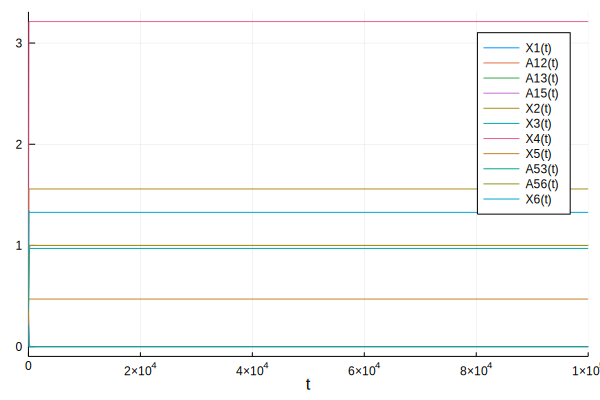

In [31]:
# population dynamics
@time plot(sol)

In [32]:
# want frequency of co-occurance at 10^5
# species, data points
size(sol)

(11, 105)

In [33]:
last(sol[:])

11-element Array{Float64,1}:
  2.786932747799859e-72
  1.0000000000000004   
 -5.972187973054726e-25
  3.344504186044127e-20
  1.55787212323741     
  0.970344954051454    
  3.2123108286857756   
  0.47086132419467014  
  4.627956307541945e-29
  1.0                  
  1.326840607103098    

In [34]:
just_species = copy(last(sol[:]))
row = adaptive_links[:,1]
just_species = just_species[setdiff(1:end, row), :]


6×1 Array{Float64,2}:
 2.786932747799859e-72
 1.55787212323741     
 0.970344954051454    
 3.2123108286857756   
 0.47086132419467014  
 1.326840607103098    

In [35]:
# how many species survived?
function surviving(species)
    survivors = 0
    for i in 1:length(species)
        if species[i] >= 10^(-5)
        survivors += 1
        end
    end
    return survivors
end

# what proportion of original community is that?


surviving (generic function with 1 method)

In [36]:
function co_occuring(final_species, number_of_species)
    # takes array of final species densities and initial number of species
    # outputs bool of whether all species are still co-occuring
    if surviving(final_species)/number_of_species == 1.0
        return true
    else
        return false
    end
    
end

co_occuring (generic function with 1 method)

In [37]:
co_occuring(just_species, number_species)

false

In [38]:
# pile of helper functions for multiple_runs

function normalize_A_naught(rn)
    # needs to normalize the starting values of the A's of a given adaptive forager
    # takes a species list, the number of prey, and the parameter list
    # returns normalized A values 
    
    
    s_string = "0"
    s_len = length(species(rn))
    string_species = Array{String}(undef, s_len)
    number_adaptive_links = 0

    for i in 1:s_len
        string_species[i] = string(species(rn)[i])
    end

    for i in 1:s_len # step through list of species
        s_string = string_species[i][1]  # pull out first letter of species name
        if s_string == 'A'
            number_adaptive_links += 1
        end
    end

    adaptive_links = zeros(number_adaptive_links, 2)
    adaptive_index = 1
    for i in 1:s_len 
        s_string = string_species[i][1]  
        if s_string == 'A'
            adaptive_links[adaptive_index,1] = i
            adaptive_links[adaptive_index,2] = rand()
            adaptive_index += 1
        end
    end

    norm_sum = sum(adaptive_links[:,2])

    for i in 1:number_adaptive_links
        adaptive_links[i,2] = adaptive_links[i,2] /norm_sum
    end
        
    init_pop = zeros(length(species(rn)));
    for i in 1:length(species(rn))
        init_pop[i] = rand()
    end
    
    for i in 1:number_adaptive_links
        j = Int(adaptive_links[i,1])
        init_pop[j] = adaptive_links[i,2]
    end
    
    return init_pop, adaptive_links
    
end

function stability(sol, adaptive_links)
    just_species = copy(last(sol[:]))
    row = adaptive_links[:,1]
    just_species = just_species[setdiff(1:end, row), :]
    bool = co_occuring(just_species, length(last(sol)))
    return bool
end

stability (generic function with 1 method)

In [39]:
# multi run function

function multiple_runs(rn, model, number_species, number_of_runs, connectance, adaptivity)
    # needs to generate and analyze some number of food webs 
    # takes an interger number of runs to perform and some meta-parameters
    # outputs the proportion of runs in which all species survivied 10^5
    

    species_list = generate_species(number_species, model, adaptivity);

    interaction_matrix, number_of_prey = build_interaction_matrix(species_list, 
        model, connectance=connectance);
    
    #rn = @empty_reaction_network

    generate_ode_system(rn, interaction_matrix, species_list, number_of_prey)
    species(rn);
    addodes!(rn);
    p_list = params(rn);
    #random_params, string_params = parameter_generator(species_list, p_list);
    #float_param_list = build_param_val_list(string_params, random_params);
        
    init_pop, adaptive_links = normalize_A_naught(rn);
    #init_pop = rand(length(species(rn)))
    float_param_list = rand(length(p_list))
    
    
        
        return init_pop, adaptive_links, float_param_list
        
end

multiple_runs (generic function with 1 method)

In [40]:
number_of_runs = 2
connectance_scenarios = 6
adaptivity_scenarios = 6

run_array = zeros(connectance_scenarios,number_of_runs,adaptivity_scenarios)

rn = @empty_reaction_network
A=1
for adapt in 0:0.2:1
    
    C=1
 for connect in 0:0.2:1
   
    for run in 1:number_of_runs
    rn = @empty_reaction_network

    init_pop, adaptive_links, float_param_list = multiple_runs(rn, "random", 3, 1, connect, adapt)
    u₀ = init_pop
    p = float_param_list
    tspan= (0.0,100.0)
    oprob = ODEProblem(rn, u₀, tspan, p)
    sol= solve(oprob);
    #print(stability(sol, adaptive_links), " ")
    run_array[A,run,C] = stability(sol, adaptive_links)
        end
         C +=1
    end
    A+=1
end

In [1]:
sum(run_array)/number_of_runs


UndefVarError: UndefVarError: run_array not defined